In [1]:
%matplotlib inline

import sys
import os
sys.path.append("../../..")

import numpy as np
import re
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
import my_packages.My_Geoprocess as mgp

from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score


## Get Rasters Informations, size, Geotransform... following one of the grid

In [2]:
ClassifFolder = '../../../Poe/Resultats/Classifications/'
ImagesFolder = '../../../Poe/Images/Acolyte/S2A_MSIL1C_20180305T230901_N0206_R101_T58KEB_20180306T00234_bisAco/S2A_MSI_2018_03_05_23_09_01_T58KEB_L2R_tif/'
raster_wavelength = ['560']
raster_Name = ['rhos_' + l + '.tif' for l in raster_wavelength]

src_ds = gdal.Open(ImagesFolder+raster_Name[0], gdal.GA_ReadOnly)
band = src_ds.GetRasterBand(1)
GT_ds = src_ds.GetGeoTransform()
proj = src_ds.GetProjection()
RasterHeight, RasterWidth = (src_ds.RasterYSize, src_ds.RasterXSize)
print(RasterHeight, RasterWidth)

10980 10980


## Define Rasters footprint

In [3]:
# Define Raster Footprint
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (164.99980652185837, -21.791778063706154) 
Lower right corner :  (166.0548316017674, -20.79645641405817)


## Get surveyfiles (ascii), having measurement contained in rasters footprint

In [74]:
FileWorkableSur = '../../Terrain/MesuresBathy/Poe_22and23_05_2018.txt'

MeasurementFrame = pd.read_csv(FileWorkableSur)
Lon = MeasurementFrame['Lon'].astype('float64').values
Lat = MeasurementFrame['Lat'].astype('float64').values

CoordinatesSet = np.stack([Lon,Lat], axis=1)
depth = MeasurementFrame['Depth'].astype('float32').values

del MeasurementFrame, Lon, Lat

##  Convert measurements coordinate in pixels coordinate (+ checking process)

In [92]:
testLocation = np.array([[166.0618842, -21.7883184],
                         [166.0618359, -21.7882778],
                         [166.0619313, -21.7883652],
                         [166.0618326, -21.7883166]])

# Define pixel location of measured data
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)
(Px, Py) = mgp.GetPixel(ctInv, inv_geometrix, testLocation,integer=False)
Location = ['Center', 'UpperLeft', 'LowerRight','PreviousNext']
[print(Loc, pxx, pyy) for Loc, pxx, pyy in zip(Location, Px,Py)]

# Project coordinates in pixel coordinates then filter measured data projected outside image extent
px, py = mgp.GetPixel(ctInv, inv_geometrix, CoordinatesSet,integer=False) # Case for dense field data, need interger=False for wheigtering or interpolation
indexOut = np.logical_or(np.logical_or(py>RasterHeight-1,py<0), np.logical_or(px>RasterWidth-1,px<0))
px, py = px[~indexOut], py[~indexOut]

# Adjust water depth following the Tide at the image sensor Time
TideHeight = 1.31 # Height of tide from SHOM website
depth = depth[~indexOut]+TideHeight

# filter measured data with negative depth (due to tide)
indexOut = depth<0
print('Number of point with negative depth :', np.sum(indexOut))
px, py, depth = px[~indexOut], py[~indexOut], depth[~indexOut]
assert px.shape==py.shape and px.shape == depth.shape

no int
Center 10979.5091234 10979.4685216
UpperLeft 10979.0128596 10979.0156563
LowerRight 10979.9925083 10979.9899339
PreviousNext 10978.9757872 10979.444926
no int
Number of point with negative depth : 0


<function matplotlib.pyplot.show>

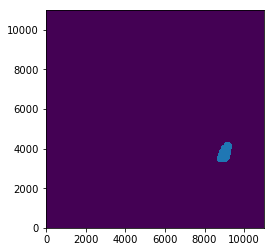

In [95]:
plt.imshow(np.ones((RasterHeight, RasterWidth)))
plt.scatter(py,px)
plt.ylim(max(plt.ylim()), min(plt.ylim()))
plt.xlim(max(plt.ylim()), min(plt.ylim()))
plt.show

In [90]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, **kwargs)
    Plot lines and/or markers to the
    :class:`~matplotlib.axes.Axes`.  *args* is a variable length
    argument, allowing for multiple *x*, *y* pairs with an
    optional format string.  For example, each of the following is
    legal::
    
        plot(x, y)        # plot x and y using default line style and color
        plot(x, y, 'bo')  # plot x and y using blue circle markers
        plot(y)           # plot y using x as index array 0..N-1
        plot(y, 'r+')     # ditto, but with red plusses
    
    If *x* and/or *y* is 2-dimensional, then the corresponding columns
    will be plotted.
    
    If used with labeled data, make sure that the color spec is not
    included as an element in data, as otherwise the last case
    ``plot("v","r", data={"v":..., "r":...)``
    can be interpreted as the first case which would do ``plot(v, r)``
    using the default line style and color.
    
    If not used wi

## Get workingIndex or Index of classification and bathymetry mapping
###### In others words :        ClassifIndex = ~Soil x ~DeepOcean x CroppedImage
######                                     ClassifIndex.shape == Initial_Rasters.shape

(10980, 10980)


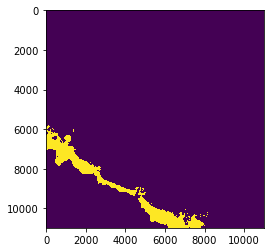

In [77]:
Lagoon = 'Mask/Lagoon.tif'

ClassifIndex = gdal.Open(ImagesFolder + Lagoon, gdal.GA_ReadOnly)
ClassifIndex = ClassifIndex.GetRasterBand(1).ReadAsArray().astype(bool)
print(ClassifIndex.shape)
plt.imshow(ClassifIndex)

## Create index(SurveyIndex) indicating the presence of measurements in a pixel
## Create dictionary(Dicto) of depths measured at a pixel location

In [78]:
# Create sub (2d) index for measured pixel
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)

## Compute Statistics on pixels containing measurements 

In [ ]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.std(Dicto[(i, j)])

## Load Optical Data
### WARNING: Poe special case -> to avoid bigger backup size, data need to be resize at Rasters dimension

In [ ]:
# Load Data at reduce backup size
npzfile = np.load('../../../Poe/CompressedData/SRXData.npz')
Xc = npzfile['Ratios'] # Optical data at croped shape (reduce backup size)
RatiosKeys = npzfile['Keys'] # Keys defining order of recorded ratios 

# Creation of arrays at Raster Size
X = np.full((RasterHeight, RasterWidth, Xc.shape[2]), np.nan) # Final array of optical data at Raster size 
ValidMap = np.full((RasterHeight, RasterWidth), False) # Map of area of Interest -> cropped area reducing backup size

# Translation of the data at the suitable dimension
X[5000:,0:8500,:] = Xc[:,:,:]
ValidMap[5000:,0:8500] = True
del Xc

# Useless here...
ToclassifyIndex = np.logical_and(ValidMap,ClassifIndex)
X.shape

## Special case in Poe, Area of interest for specific calibration manually created

In [ ]:
ShapeFolder = '../../../Poe/Shapes/'
RoiPathName = 'SheratonLagoon.shp'

ResctictedLagoon = mgp.create_mask_from_vector(ShapeFolder + RoiPathName,  RasterHeight, RasterWidth, GT_ds, proj, target_value=1, format=gdal.GDT_Byte)
ResctictedLagoon = ResctictedLagoon.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(ResctictedLagoon)

## Visual check !

In [ ]:
# Manual cropping for better visual rendering
ScatterIndex = np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0)
CroppedDepth = SurveyValues[8800:9400,3500:4650] # Average deph of pixels contained in the visual cropped

# Scatter coordinates and image in rendered dimension
x,y = np.where(ScatterIndex)
Im = ResctictedLagoon[8800:9400,3500:4650]

# Plot
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(Im)
plt.scatter(y,x,s=80, c='r')
for i in range(len(x)):
    ax.annotate(CroppedDepth[ScatterIndex][i], (y[i]-10,x[i]+10), color='red', size=20)
print("Nombre de pixel comportant une mesure immergées:",len(x))

## Creation of calibration dataset

In [ ]:
assert X.shape[:2]==SurveyValues.shape
ind = ResctictedLagoon * (SurveyIndex>0) # Index of calibration data
Data_x = X[ind,:] # model optical descriptors
Data_y = SurveyValues[ind].reshape(np.sum(ind),) # model target depth

## release memory

In [ ]:
del X

## exploratory statistics

In [ ]:
for i in range(Data_x.shape[1]):
    print(str(RatiosKeys[i]),'correlation : ',np.corrcoef(Data_x[:,i],Data_y)[0,1])
    print("="*10)
mgp.plot_ResRegPlots(Data_x, Data_y, Scale=True, SetTitles=False, Titles=RatiosKeys)

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(20, 8))
for i, ax in enumerate(fig.axes):
    ax.scatter(Data_x[:,i],Data_y, s=4)
    ax.set_title('Band  ' + str(RatiosKeys[i]))
    ax.set_ylabel('Depth')
    ax.set_xlabel('Optical Signal')

In [ ]:
x = Data_x
y = Data_y

In [ ]:
from scipy import stats
used_x = Data_x[:,1].reshape(len(y),)
plt.scatter(used_x,y)
buffer = np.array(stats.linregress(used_x,y)[:])
Interval = np.array([np.min(x),np.max(x)])
plt.plot(Interval, Interval*buffer[0]+buffer[1], c='k')
plt.xlabel('Optical Signal')
plt.ylabel('predicted Depth')


# Huber Regression

In [ ]:
lr = linear_model.RidgeCV(cv=115,fit_intercept=True, alphas= (10 ,0.1))

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

In [ ]:
lr.score(x,y)

# Simple Crossvalidated Linear model

In [ ]:
lr = linear_model.LinearRegression()

# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
#predicted = cross_val_predict(lr, x, y, cv=len(y))
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# Cross Validated RANSAC

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
inlierMat = np.full((y.shape[0], 1, len(y)),np.nan, np.float)
#lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)
lr = linear_model.RANSACRegressor(min_samples=0.5, residual_threshold=0.2)
counterCheck = 0


for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    inlierMat[train_index, 0, counterCheck] = lr.inlier_mask_
    counterCheck = counterCheck + 1
    
col = np.nansum(inlierMat, axis=2)
fig, ax = plt.subplots(figsize=(15,15))
im = ax.scatter(y, predicted,c=col, cmap='jet')
plt.colorbar(im)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('R2 : '+str(r2_score(y, predicted)))
plt.show()

# TheilSenRegressor

In [ ]:
loo = LeaveOneOut()
loo.get_n_splits(x)
predicted = np.full(y.shape,np.nan, np.float)
lr = linear_model.TheilSenRegressor()
counterCheck = 0

for train_index, test_index in loo.split(x):
    lr.fit(x[train_index], y[train_index])
    predicted[test_index] = lr.predict(x[test_index])
    counterCheck = counterCheck + 1
    
fig, ax = plt.subplots()
im = ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

# RANSAC Whithout cross validation

In [ ]:
lr = linear_model.RANSACRegressor(min_samples=0.9, max_trials=100000, residual_threshold=0.4,stop_probability=0.999)


# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = lr.fit(x, y).predict(x)

fig, ax = plt.subplots()
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
ax.scatter(y, predicted, c=lr.inlier_mask_, s=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
y = SurveyValues[ind].reshape(np.sum(ind),)
plotInd = (col>5).reshape(len(y),)
ind = ResctictedLagoon[8800:9400,3500:4650]
fig = plt.figure(figsize=(50,50))
plt.imshow(ind)
plt.scatter(yIm[plotInd],xIm[plotInd],s=80, c='b')
plt.scatter(yIm[~plotInd],xIm[~plotInd],s=80, c='r')
print("Nombre de point extreme :",np.sum(~plotInd))

In [ ]:
testImage = testImage[8800:9400,3500:4650]**0.4

In [ ]:
xIm,yIm = np.where(np.logical_and(ResctictedLagoon[8800:9400,3500:4650],SurveyIndex[8800:9400,3500:4650]>0))
fig = plt.figure(figsize=(50,50))
plt.imshow(testImage)
plt.scatter(yIm,xIm,s=80, c='r')